## 収入調査データセット

データの取得
- https://cran.r-project.org/web/packages/arules/readme/README.html

データの説明
- https://www.rdocumentation.org/packages/arules/versions/1.6-6/topics/Income
- ショッピングモールでの収入とその他属性のアンケート結果

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

income_columns = ['income', 'sex', 'marital status', 'age', 'education', 'occupation',
                  'years in bay area', 'dual incomes', 'number in household',
                  'number of children', 'householder status', 'type of home', 
                  'ethnic classification', 'language in home']

income = pd.read_csv('data/Income.csv', names=income_columns)
# 列ごとの欠損値の数
print(income.isna().sum())
# データの確認
income.head(2)

income                   0
sex                      0
marital status           0
age                      0
education                0
occupation               0
years in bay area        0
dual incomes             0
number in household      0
number of children       0
householder status       0
type of home             0
ethnic classification    0
language in home         0
dtype: int64


,income,sex,marital status,age,education,occupation,years in bay area,dual incomes,number in household,number of children,householder status,type of home,ethnic classification,language in home
0,"income=$40,000+",sex=male,marital status=married,age=35+,education=college graduate,occupation=homemaker,years in bay area=10+,dual incomes=no,number in household=2+,number of children=1+,householder status=own,type of home=house,ethnic classification=white,language in home=english
1,"income=$40,000+",sex=female,marital status=married,age=14-34,education=college graduate,occupation=professional/managerial,years in bay area=10+,dual incomes=yes,number in household=1,number of children=1+,householder status=rent,type of home=apartment,ethnic classification=white,language in home=english


<hr>

## データの調査

- 収入
- 収入と年齢の関係
- 収入と教育の関係

### 収入データの可視化

収入を表す income 列の頻度を表す棒グラフを描画

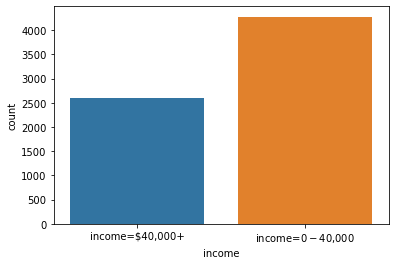

In [2]:
# 収入 income の棒グラフ
sns.countplot(x=income.income)
plt.show()

### クロス集計

クロス集計でデータの関係を表にまとめる

In [3]:
# 収入と年齢の関係（クロス集計）
pd.crosstab(income.income, income.age)

age,age=14-34,age=35+
income,,
"income=$0-$40,000",3002,1278
"income=$40,000+",1023,1573


In [4]:
# 収入と教育の関係（クロス集計）
pd.crosstab(income.income, income.education)

education,education=college graduate,education=no college graduate
income,,
"income=$0-$40,000",829,3451
"income=$40,000+",1198,1398


年齢が高い、学歴が高い方が、収入が多い傾向は読み取れる。

<hr>

### データ形式の変換

データフレーム income から、アソシエーション分析に必要なデータ構造を生成

- 購買履歴のデータ: df
  - TID, ItemID 列からなる pandas DataFrame
- ItemIDとアイテム名の辞書: item_dict
  - キーが ItemID, バリューがアイテム名の dict 型

In [5]:
# すべての列のユニークな値をリストに格納
dict_list = []
for row in income_columns:
    dict_list.extend(income[row].unique())

# ItemIDとアイテム名の辞書（キー：ItemID、値：アイテム名）
item_dict = {}
# ItemID辞書（キー：アイテム名、値：ItemID）
itemid_dict = {}
# アイテム辞書に新規アイテムを追加する時のItemID
item_id = 0

In [6]:
# item_idの割当
for item in dict_list:
    itemID = 'I' + str(item_id)
    itemid_dict[item] = itemID
    item_dict[itemID] = item
    item_id = item_id + 1

# 確認
item_dict

{'I0': 'income=$40,000+',
 'I1': 'income=$0-$40,000',
 'I2': 'sex=male',
 'I3': 'sex=female',
 'I4': 'marital status=married',
 'I5': 'marital status=single',
 'I6': 'marital status=divorced',
 'I7': 'marital status=cohabitation',
 'I8': 'marital status=widowed',
 'I9': 'age=35+',
 'I10': 'age=14-34',
 'I11': 'education=college graduate',
 'I12': 'education=no college graduate',
 'I13': 'occupation=homemaker',
 'I14': 'occupation=professional/managerial',
 'I15': 'occupation=student',
 'I16': 'occupation=retired',
 'I17': 'occupation=unemployed',
 'I18': 'occupation=laborer',
 'I19': 'occupation=sales',
 'I20': 'occupation=clerical/service',
 'I21': 'occupation=military',
 'I22': 'years in bay area=10+',
 'I23': 'years in bay area=1-9',
 'I24': 'dual incomes=no',
 'I25': 'dual incomes=yes',
 'I26': 'dual incomes=not married',
 'I27': 'number in household=2+',
 'I28': 'number in household=1',
 'I29': 'number of children=1+',
 'I30': 'number of children=0',
 'I31': 'householder status=ow

In [7]:
# トランザクションのリスト
trans_list = []

for tid in range(0, len(income)):
    for item in income.iloc[tid, :]:
        trans_list.append([tid, itemid_dict[item]])

# 確認
#trans_list

# pandas DataFrame に変換、確認
df = pd.DataFrame(trans_list, columns=['TID', 'ItemID'])
df

,TID,ItemID
0,0,I0
1,0,I2
2,0,I4
3,0,I9
4,0,I11
...,...,...
96259,6875,I30
96260,6875,I32
96261,6875,I35
96262,6875,I40


<hr>

### 相関ルール生成のプログラム

In [8]:
# TIDを重複排除のため集合に変換
all_trans = set(df.TID)
# |D| : トランザクション数
all_trans_len = len(all_trans)

# 1つのitemについて、そのitemを含むTIDの集合を辞書で管理
count_dict = {}
# 全てのitemについて、そのitemを含むTIDの集合をtrans_setに追加
for item in df.ItemID.unique():
    count_dict[item] = set(df[df['ItemID'] == item].TID)

In [9]:
from functools import reduce
from itertools import combinations

# サポートカウントの計算
def support_count(item_set):
    trans_set = []
    # item_setの各itemについて、そのitemを含むTIDの集合をtrans_setに追加
    for item in item_set:
        trans_set.append(count_dict[item])
    # trans_set の確認用
    # print(trans_set)
    # 全itemを含むTIDは、各itemを含むTIDの集合の積集合の要素数
    return len(reduce(lambda a, x: a & x, trans_set, all_trans))

# サポートの計算
def support(itemset):
    return support_count(itemset) / all_trans_len

# コンフィデンスの計算
def confidence(itemset_A, itemset_B):
    return support_count(itemset_A | itemset_B) / support_count(itemset_A)

# Generate_Candidates(L_{k-1}, k, min_sup_count)
def generate_candidates(L, k, min_sup_count):
    Ck = []
    for l1 in L:
        for l2 in L:
            # listのインデックスは 0 始まり
            if l1[0:k - 2] == l2[0:k - 2] and l1[k - 2] < l2[k - 2]:
                c = sorted(list(set(l1) | set(l2)))
                # print('k={}: {} | {} = {}'.format(k, l1, l2, c))
                for i in combinations(c, k - 1):
                    if support_count(i) < min_sup_count:
                        break
                else:   # 上のbreak文が実行されなかった場合
                    Ck.append(c)
    return Ck

# Apriori アルゴリズムの処理
def apriori():
    # 全てのアイテム
    all_items = sorted(list(set(df.ItemID)))

    # 頻出アイテムセットの集合を格納するdict型変数
    L = {}

    # L1 ← 1つのアイテムからなる頻出アイテムセットの集合
    L[1] = [[i] for i in all_items if support_count({i}) >= min_sup_count]
    # print('L1 = ', L[1])

    # k ← 2
    k = 2

    while L[k - 1] != []:
        Lk = []
        Ck = generate_candidates(L[k - 1], k, min_sup_count)
        for c in Ck:
            # print('{} {}'.format(c, support_count(c)))
            if support_count(c) >= min_sup_count:
                Lk.append(c)
        L[k] = Lk
        # print('L{} = {}'.format(k, L[k]))
        k = k + 1
    
    # 和集合
    L_union = []
    for ln in L.values():
        for l in ln:
            L_union.append(l)

    return L_union

# 相関ルールの生成
def create_assoc_rules(l, v=0):
    # 相関ルールの初期化
    assoc_rule = []
    # 全ての真部分集合 all_s のリストを初期化
    all_s = []
    # 全ての真部分集合 all_s の作成
    for n in range(1, len(l)):
        for i in combinations(l, n):
            all_s.append(list(i))
    # all_sの確認
    #print('all_s = {}'.format(all_s))

    # lのサポートカウント
    l_support_count = support_count(l)

    # 各真部分集合についてコンフィデンスを計算
    for s in all_s:
        # コンフィデンス(s ⇒ (l-s))
        s_support_count = support_count(s)
        cnfd = l_support_count / s_support_count
        # 確認用
        if (v > 0):
            print('{} {}/{}={}'.format(s, l_support_count, s_support_count, cnfd))
        # 最小コンフィデンス以上のルールを相関ルールに追加
        if cnfd >= min_confidence:
            # (l-s)
            l_s = [i for i in l if i not in s]
            sprt = l_support_count / all_trans_len
            lift = cnfd / (support_count(l_s) / all_trans_len)
            assoc_rule.append([s, l_s, sprt, cnfd, lift])

    return assoc_rule

# 全ての相関ルールの生成
def create_all_assoc_rules():
    # 相関ルールの初期化
    assoc_rules = []
    # Aprioriアルゴリズムで求めた全ての頻出アイテムセットから相関ルールを生成
    for l in apriori():
        rules = create_assoc_rules(l)
        if rules != []:
            for r in rules:
                assoc_rules.append(r)

    return pd.DataFrame(assoc_rules, columns=['L', 'R', 'support', 'confidence', 'lift'])

<hr>

## 相関ルールの生成、リフト値の計算

1. Aprioriアルゴリズムを適用し、相関ルールを生成する
2. 各相関ルールについて、リフト値を計算する

In [10]:
%%time
# 最小サポート: 15%
min_sup = 0.15
# 最小コンフィデンス: 50%
min_confidence = 0.5

# 最小サポートカウント
min_sup_count = all_trans_len * min_sup
# 表示
print('all_trans_len:', all_trans_len)
print('min_sup_count:', min_sup_count)

# 相関ルールの生成
print('全ての相関ルールの生成:')
df_rules = create_all_assoc_rules()

# 確認
# - リフト値でソート（降順）
df_rules.sort_values('lift', ascending=False)

all_trans_len: 6876
min_sup_count: 1031.3999999999999
全ての相関ルールの生成:
CPU times: user 17.4 s, sys: 0 ns, total: 17.4 s
Wall time: 17.4 s


,L,R,support,confidence,lift
9042,"[I10, I34, I5]","[I26, I33]",0.153723,0.727961,3.642986
9034,"[I26, I33]","[I10, I34, I5]",0.153723,0.769287,3.642986
4398,[I33],"[I10, I34, I5]",0.153723,0.749645,3.549974
9032,[I33],"[I10, I26, I34, I5]",0.153723,0.749645,3.549974
9049,"[I10, I26, I34, I5]",[I33],0.153723,0.727961,3.549974
...,...,...,...,...,...
1,[I0],[I12],0.203316,0.538521,0.763636
1191,"[I12, I34]",[I28],0.223095,0.523014,0.755990
282,"[I0, I47]",[I12],0.188918,0.532159,0.754614
8589,"[I10, I12, I26, I5]",[I28],0.155614,0.519670,0.751156


<hr>

### 高収入の関連要因

相関ルールから、ルール A⇒B のBに ```income=$40,000+``` が含まれる相関ルールを表示
- ItemID は 'I0'
```
'I0': 'income=$40,000+'
```

In [11]:
df_rules_I0 = df_rules[df_rules['R'].map(lambda x: True if 'I0' in x else False)]
df_rules_I0.sort_values('lift', ascending=False)

,L,R,support,confidence,lift
2276,"[I25, I47]","[I0, I4]",0.150960,0.645522,2.723075
2272,[I25],"[I0, I4, I47]",0.150960,0.595867,2.650181
317,[I25],"[I0, I4]",0.158086,0.623995,2.632265
6792,"[I34, I4, I47]","[I0, I31]",0.165212,0.631111,2.590758
2428,"[I31, I4]","[I0, I9]",0.154305,0.590100,2.579484
...,...,...,...,...,...
2244,"[I22, I34, I39]",[I0],0.153287,0.516667,1.368490
2461,"[I34, I39, I47]",[I0],0.207097,0.516316,1.367562
388,"[I34, I39]",[I0],0.209279,0.515217,1.364649
2338,"[I30, I34, I47]",[I0],0.150960,0.511330,1.354355


In [12]:
# アイテム名に変換して表示
df_high_rules = df_rules_I0.sort_values('lift', ascending=False)
for rule in df_high_rules.itertuples():
    L_list = []
    R_list = []
    for i in rule.L:
        L_list.append(item_dict[i])
    for i in rule.R:
        R_list.append(item_dict[i])
    print(L_list, '=>', R_list)

['dual incomes=yes', 'language in home=english'] => ['income=$40,000+', 'marital status=married']
['dual incomes=yes'] => ['income=$40,000+', 'marital status=married', 'language in home=english']
['dual incomes=yes'] => ['income=$40,000+', 'marital status=married']
['type of home=house', 'marital status=married', 'language in home=english'] => ['income=$40,000+', 'householder status=own']
['householder status=own', 'marital status=married'] => ['income=$40,000+', 'age=35+']
['type of home=house', 'marital status=married'] => ['income=$40,000+', 'householder status=own', 'language in home=english']
['type of home=house', 'marital status=married'] => ['income=$40,000+', 'householder status=own']
['marital status=married', 'age=35+'] => ['income=$40,000+', 'householder status=own']
['householder status=own', 'ethnic classification=white'] => ['income=$40,000+', 'language in home=english', 'age=35+']
['type of home=house', 'language in home=english', 'age=35+'] => ['income=$40,000+', 'hous